Epoch 1/10, Loss: 0.7990, Accuracy: 0.7935
Epoch 2/10, Loss: 0.6399, Accuracy: 0.7931
Epoch 3/10, Loss: 0.6150, Accuracy: 0.7932
Epoch 4/10, Loss: 0.6091, Accuracy: 0.7932
Epoch 5/10, Loss: 0.6007, Accuracy: 0.8025
Epoch 6/10, Loss: 0.5983, Accuracy: 0.7985
Epoch 7/10, Loss: 0.5940, Accuracy: 0.7939
Epoch 8/10, Loss: 0.5870, Accuracy: 0.8075
Epoch 9/10, Loss: 0.5869, Accuracy: 0.8017
Epoch 10/10, Loss: 0.5840, Accuracy: 0.8056


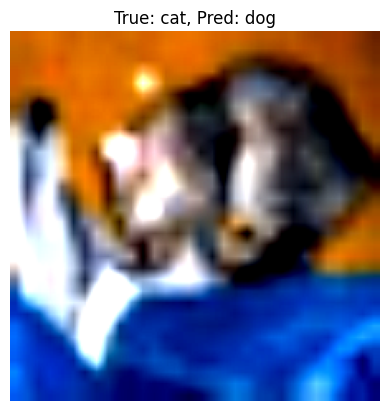

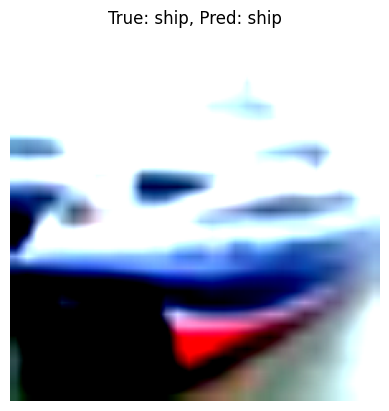

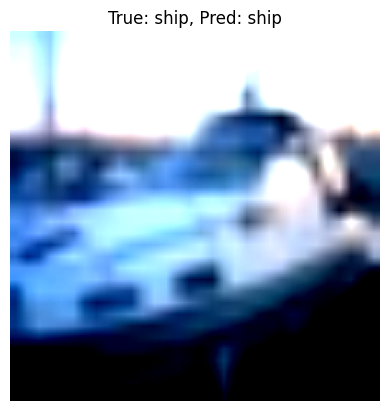

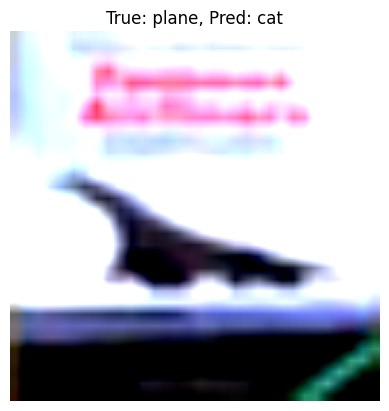

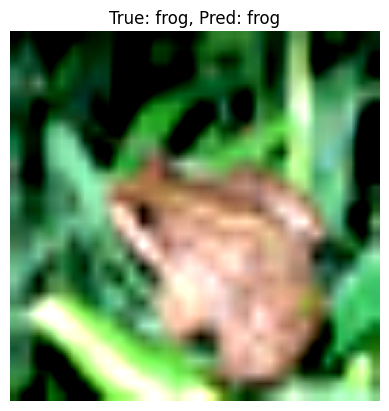

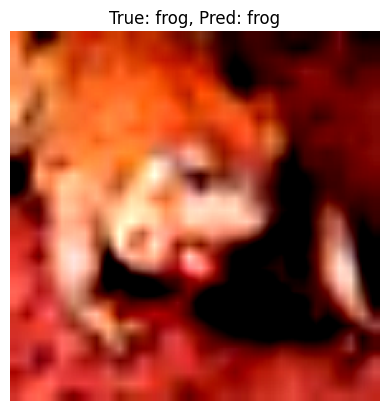

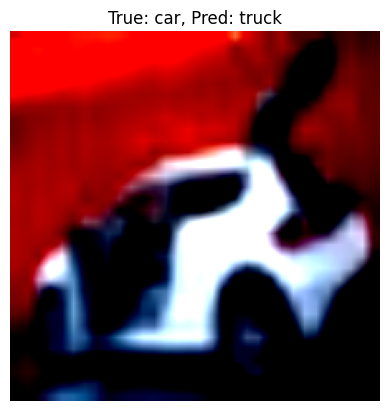

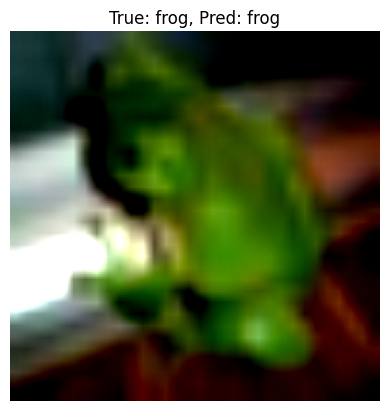

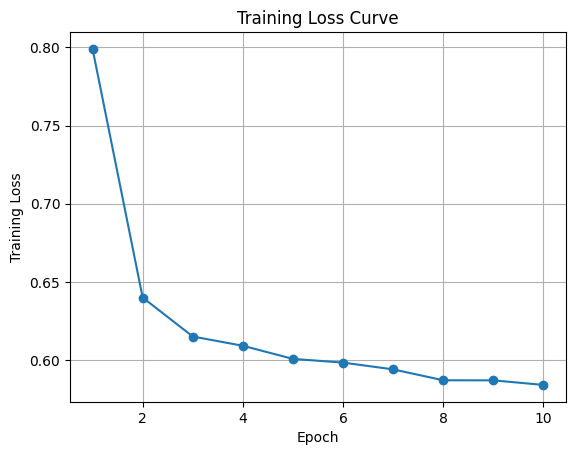

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Device configuration (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations (resize and normalize)
transform = transforms.Compose([
    transforms.Resize(224),  # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load pretrained ResNet18 and modify the final layer
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  # CIFAR-10 has 10 classes
model = model.to(device)

# Loss and optimizer (only for the final layer parameters)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training function for one epoch
def train_epoch():
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Evaluation function (accuracy)
def evaluate():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Class names for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_epochs = 10
loss_history = []

# Training loop
for epoch in range(num_epochs):
    loss = train_epoch()
    acc = evaluate()
    loss_history.append(loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

# Save trained model weights
torch.save(model.state_dict(), "resnet18_finetuned_cifar10.pth")

# Function to show images with true and predicted labels
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Get some test images and predictions
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Corrected here
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Show first 8 images with titles
for i in range(8):
    imshow(images[i].cpu(), f'True: {classes[labels[i]]}, Pred: {classes[predicted[i]]}')

# Plot training loss curve
plt.figure()
plt.plot(range(1, num_epochs+1), loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()
